In [96]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from obspy import read
import obspy
import os
from pprint import pprint
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import LSTM, Dropout, Dense, Input
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from scipy.io.wavfile import write
from pydub import AudioSegment
import matplotlib.pyplot as plt

C:\Users\Andrery\AppData\Roaming\Python\Python311\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [23]:
# Вывести список доступных устройств
physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))

# Если нужно использовать конкретные GPU (если их несколько)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  0


In [25]:
test_data_path  = "./data/lunar/test/data/S12_GradeB"
train_data_path = "./data/lunar/training/data/S12_GradeA"

### Load data

In [42]:
test_files = os.listdir(test_data_path)
train_files = os.listdir(train_data_path)
count_test_files = len(test_files)
count_train_files = len(train_files)
print(count_test_files)
print(count_train_files)
if count_test_files > count_train_files:
    test_files = test_files[:count_train_files]
else:
    train_files = train_files[:count_test_files]
test_files  = test_files[:4]
train_files = train_files[:4]
count_test_files = len(test_files)
count_train_files = len(train_files)
print(count_test_files)
print(count_train_files)

128
152
4
4


In [44]:
pprint(test_files[:2])
pprint(train_files[:2])

['xa.s12.00.mhz.1969-12-16HR00_evid00006.csv',
 'xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed']
['xa.s12.00.mhz.1970-01-19HR00_evid00002.csv',
 'xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed']


In [46]:
train_data, test_data, \
train_mseed_data, test_mseed_data = \
[], [], [], []
for i in range(0, count_test_files, 2):
    # print(f'{train_data_path}/{train_files[i]}')
    train_data.append(pd.read_csv(f'{train_data_path}/{train_files[i]}', encoding='utf-8'))
    # print(f'{test_data_path}/{test_files[i]}')
    test_data.append(pd.read_csv(f'{test_data_path}/{test_files[i]}', encoding='utf-8'))
    
for i in range(1, count_test_files, 2):
    # print(f'{train_data_path}/{train_files[i]}')
    train_mseed_data.append(read(f'{train_data_path}/{train_files[i]}'))
    # print(f'{test_data_path}/{test_files[i]}')
    test_mseed_data.append(read(f'{test_data_path}/{test_files[i]}'))
print(len(train_data))
print(len(test_data))
print(len(train_mseed_data))
print(len(test_mseed_data))

# train_stream = train_mseed[0].data
# test_stream = test_mseed[0].data

2
2
2
2


### Data Normalization

In [49]:
scaler = StandardScaler()

for i in range(0, len(train_data)):
    # train_data[i]['time_abs'] = pd.to_datetime(train_csv['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
    train_data[i]['velocity_normalized'] = scaler.fit_transform(train_data[i][['velocity(m/s)']])
    test_data[i]['velocity_normalized']  = scaler.fit_transform(test_data[i][['velocity(m/s)']])


In [51]:
train_data[1].head()

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s),velocity_normalized
0,1970-03-25T00:00:00.440000,0.000000,-5.481780e-15,0.005003
1,1970-03-25T00:00:00.590943,0.150943,-6.878653e-15,0.005000
2,1970-03-25T00:00:00.741887,0.301887,-7.486137e-15,0.004998
3,1970-03-25T00:00:00.892830,0.452830,-7.191481e-15,0.004999
4,1970-03-25T00:00:01.043774,0.603774,-6.287278e-15,0.005001


### Init model

In [68]:
window_size = 10  
num_epochs = 2
batch_size = 3200  

def create_model():
    model = Sequential()
    model.add(Input(shape=(window_size, 1)))  
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))  

    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))  

    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))  

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.summary()
    return model

### Fit model

In [73]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
model = create_model()
for i in range(len(train_data)):

    features = train_data[i]['velocity_normalized'].values
    stream = train_mseed_data[i]

    if len(stream) == 0:
        print(f"Stream {i} is empty.")
        continue

    X, y = [], []
    for trace in stream:
        target = trace.data

        for j in range(len(features) - window_size):
            if j + window_size < len(target):
                X.append(features[j:j + window_size])
                y.append(target[j + window_size])  

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    model.fit(X, y, epochs=num_epochs, batch_size=batch_size, callbacks=[early_stopping])

    print(f"Model trained on file {i + 1}/{len(train_data)}")

model.save('lunar_model.h5')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 10, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 10, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,369 (243.63 KB)

 Trainable params: 62,369 (243.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - loss: 6.5510e-05 - mae: 0.0035
Epoch 2/2
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - loss: 2.4198e-06 - mae: 7.3453e-04
Model trained on file 1/2
Epoch 1/2
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - loss: 2.3314e-06 - mae: 9.7131e-04
Epoch 2/2
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - loss: 1.1411e-06 - mae: 6.7928e-04


Model trained on file 2/2


### Get Predictions

In [76]:
# for i in range(len(test_data)):
features = test_data[0]['velocity_normalized'].values
stream = test_mseed_data[0]


X_test = []
y_true = []
for trace in stream:
    target = trace.data

    for j in range(len(features) - window_size):
        if j + window_size < len(target):
            X_test.append(features[j:j + window_size])
            y_true.append(target[j + window_size])  

X_test = np.array(X_test)
y_true = np.array(y_true)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)

17888/17888 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step


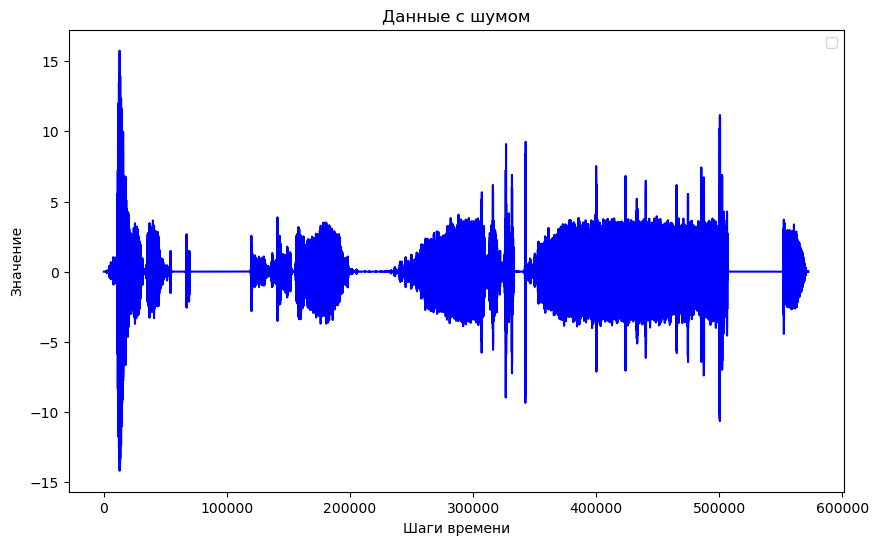

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(features, color='blue')
# plt.plot(y_pred, label='Предсказанные значения', color='red')
plt.title(f'Данные с шумом')
plt.xlabel('Шаги времени')
plt.ylabel('Значение')
plt.legend()
plt.show()


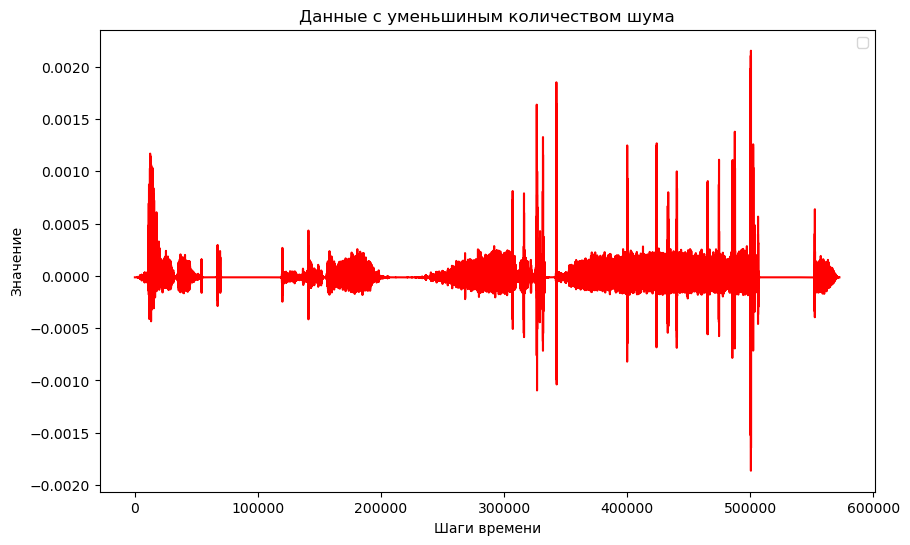

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred, color='red')
plt.title('Данные с уменьшиным количеством шума')
plt.xlabel('Шаги времени')
plt.ylabel('Значение')
plt.legend()
plt.show()


In [90]:
y_pred

array([-1.3798348e-05, -1.3797351e-05, -1.3797446e-05, ...,
       -1.3844514e-05, -1.3840818e-05, -1.3835179e-05], dtype=float32)

In [94]:
!pip install pydub

Defaulting to user installation because normal site-packages is not writeable


### Save predicted data in .wav

In [105]:
audio_array = y_pred

audio_array = audio_array / np.max(np.abs(audio_array))  
audio_array = (audio_array * 32767).astype(np.int16) 

samplerate = 44100  
write("lunar_seismic.wav", samplerate, audio_array)

audio = AudioSegment.from_wav("lunar_seismic.wav")

print("Конвертация завершена: lunar_seismic.wav")

Конвертация завершена: lunar_seismic.wav
